# What variables may affect the age of police fatalities?
Why are police officers shooting younger people in certain cities in the United States?  While there are many possible answers, the findings of such a study may be useful in introducing deeper questions.  For example :
1. Are there particular interventions necessary to address youth crime and gang activity?
2. Are new police trainings required to address populations differently?
3. Will preventative measures that aim to decrease crime differ from city to city?

Alternatively, is it merely the case that cities differ in their age distributions?  I will strive to analyze several variables that may contribute to such differences.

In [63]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import pylab
import seaborn as sns

from scipy.stats import ttest_ind

from matplotlib.ticker import FuncFormatter

## Data

I used the fatal police shootings data set, which spans from January 2015 - December 2017 for United States cities. Additionally, I incorporated US Census data for median income and population by city.  The 3 datasets used are:

**1. PoliceKillingsUS.csv:**([Kaggle Dataset](https://www.kaggle.com/kwullum/fatal-police-shootings-in-the-us/data))
The Washington Post is tracking more than a dozen details about each killing - including the race, age and gender of the deceased, whether the person was armed, and whether the victim was experiencing a mental-health crisis. They have gathered this information from law enforcement websites, local new reports, social media, and by monitoring independent databases such as "Killed by police" and "Fatal Encounters". The Post has also conducted additional reporting in many cases. This dataset only contains shootings in which a police officer, in the line of duty, shot and killed a civilian. It does not track deaths of people in police custody, fatal shootings by off-duty officers or non-shooting deaths.

**2. MedianHouseholdIncome2015.csv:**([Kaggle Dataset](https://www.kaggle.com/kwullum/fatal-police-shootings-in-the-us/data))
In order to investigate the link between police shootings and income, I used US Census data containing the median household income in all US cities.


**3. city_populations_2015.csv:**([Census Data](http://www.governing.com/gov-data/census/2014-city-population-estimates-data-table.html))
In order to normalize fatality counts by city, I used US Census data containing the 2015 population in all US cities.



In [2]:
#load data
median_household_income = pd.read_csv('MedianHouseholdIncome2015.csv', encoding="windows-1252")
police_killings = pd.read_csv('PoliceKillingsUS.csv', encoding="windows-1252")
city_population_2015 = pd.read_csv('city_populations_2015.csv')

#Transformations performed in Excel
#median transformation:  
#delete medians that aren't numeric
#delete non-cities
#update NY, Wash. DC
#update col names:  city, state

#city population transformation:
#Join in 2 letter codes for states
#Update Washington DC

## Data Transformation
In order to analyze age distributions across variables, I first had to group and join the 3 data sets, since police killings were at the more granular level of each individual death, and income and population data was by city.  

In order to determine a low/high income level, I used the median income level of \$48,617.50.

Additionally, I created a new variable for death count per million per year in order to normalize the death count by city by also incorporating the city's population, as well as the fact that the data spans 3 years.

In [71]:
#Group killings by city and add count (death_count)
df_killings_grouped_city_state = police_killings.groupby(['city', 'state']).size().reset_index(name='death_count').sort_values(['death_count'], ascending=[False])

#Replace the word ' city' with empty string since each city contains this string at the end
median_household_income['city'] = median_household_income['city'].str.replace(' city','')

#Join grouped death count by city with median income by city, and then with city population
df_killings_grouped_city_state_median = pd.merge(df_killings_grouped_city_state, median_household_income, on=['city','state'], how='outer')
df_killings_grouped_city_state_median_population = pd.merge(df_killings_grouped_city_state_median, city_population_2015, on=['city','state'], how='outer')

#Where cities aren't found, drop the record
df_killings_grouped_city_state_median_population = df_killings_grouped_city_state_median_population.dropna(subset=['median_income'])
df_killings_grouped_city_state_median_population = df_killings_grouped_city_state_median_population.dropna(subset=['pop'])
df_killings_grouped_city_state_median_population = df_killings_grouped_city_state_median_population.dropna(subset=['death_count'])

#median income = 48617.500000
df_killings_grouped_city_state_median_population['income_level'] = 'other'
df_killings_grouped_city_state_median_population.loc[df_killings_grouped_city_state_median_population['median_income'] <= 48617.500000, 'income_level'] = 'low'
df_killings_grouped_city_state_median_population.loc[df_killings_grouped_city_state_median_population['median_income'] > 48617.500000, 'income_level'] = 'high'
df_killings_grouped_city_state_median_population['death_count_per_million_per_year'] = ((df_killings_grouped_city_state_median_population['death_count']/df_killings_grouped_city_state_median_population['pop'])*1000000)/3


#median population = 1.051500e+05
df_killings_grouped_city_state_median_population['population_size'] = 'other'
df_killings_grouped_city_state_median_population.loc[df_killings_grouped_city_state_median_population['pop'] <= 1.051500e+05, 'population_size'] = 'low'
df_killings_grouped_city_state_median_population.loc[df_killings_grouped_city_state_median_population['pop'] > 1.051500e+05, 'population_size'] = 'high'


#median death count per million per year = 5.021565
df_killings_grouped_city_state_median_population['death_count'] = 'other'
df_killings_grouped_city_state_median_population.loc[df_killings_grouped_city_state_median_population['death_count_per_million_per_year'] <= 5.021565, 'death_count'] = 'low'
df_killings_grouped_city_state_median_population.loc[df_killings_grouped_city_state_median_population['death_count_per_million_per_year'] > 5.021565, 'death_count'] = 'high'


#Determine median income level to assign low/high income
df_killings_grouped_city_state_median_population.describe()
df_killings_grouped_city_state_median_population.head()

,city,state,death_count,median_income,pop,income_level,death_count_per_million_per_year,population_size
0,Los Angeles,CA,low,50205.0,3971883.0,high,3.273007,high
1,Phoenix,AZ,high,47326.0,1563025.0,low,6.611112,high
2,Houston,TX,low,46187.0,2296224.0,low,3.774312,high
3,Chicago,IL,low,48522.0,2720546.0,low,3.063111,high
4,Las Vegas,NV,high,50202.0,623747.0,high,11.222499,high


Once each city's population and income was joined, I finally joined all that back to the original, more detailed level in order to investigate age distributions for individual police fatalities.

In [79]:
#Create dataframe for top 15 cities with most police fatalities using normalized data
df_top_normalized = df_killings_grouped_city_state_median_population.sort_values(['death_count_per_million_per_year'], ascending=[False]).head(15)

#Add classification columns
df_killings_detail_city_state_median_population = pd.merge(police_killings, df_killings_grouped_city_state_median_population, on=['city','state'], how='inner')
df_killings_detail_city_state_median_population = df_killings_detail_city_state_median_population.dropna(subset=['age'])

df_killings_detail_city_state_median_population['armed_unarmed'] = 'other'
df_killings_detail_city_state_median_population.loc[df_killings_detail_city_state_median_population['armed'] != 'unarmed', 'armed_unarmed'] = 'armed'
df_killings_detail_city_state_median_population.loc[df_killings_detail_city_state_median_population['armed'] == '', 'armed_unarmed'] = 'other'
df_killings_detail_city_state_median_population.loc[df_killings_detail_city_state_median_population['armed'] == 'undetermined', 'armed_unarmed'] = 'other'
df_killings_detail_city_state_median_population.loc[df_killings_detail_city_state_median_population['armed'] == 'unknown weapon', 'armed_unarmed'] = 'other'
df_killings_detail_city_state_median_population.loc[df_killings_detail_city_state_median_population['armed'] == 'unarmed', 'armed_unarmed'] = 'unarmed'

#income
df_killings_detail_city_state_median_population_low_income = df_killings_detail_city_state_median_population[df_killings_detail_city_state_median_population['income_level']=='low']
df_killings_detail_city_state_median_population_high_income = df_killings_detail_city_state_median_population[df_killings_detail_city_state_median_population['income_level']=='high']

#armed
df_killings_detail_city_state_median_population_armed = df_killings_detail_city_state_median_population[df_killings_detail_city_state_median_population['armed_unarmed']=='armed']
df_killings_detail_city_state_median_population_unarmed = df_killings_detail_city_state_median_population[df_killings_detail_city_state_median_population['armed_unarmed']=='unarmed']

#population size
df_killings_detail_city_state_median_population_low_population = df_killings_detail_city_state_median_population[df_killings_detail_city_state_median_population['population_size']=='low']
df_killings_detail_city_state_median_population_high_population = df_killings_detail_city_state_median_population[df_killings_detail_city_state_median_population['population_size']=='high']

#death count
df_killings_detail_city_state_median_population_low_death = df_killings_detail_city_state_median_population[df_killings_detail_city_state_median_population['death_count']=='low']
df_killings_detail_city_state_median_population_high_death = df_killings_detail_city_state_median_population[df_killings_detail_city_state_median_population['death_count']=='high']

x_all = df_killings_detail_city_state_median_population['age'].sort_values()
x_low_income = df_killings_detail_city_state_median_population_low_income['age'].sort_values()
x_high_income = df_killings_detail_city_state_median_population_high_income['age'].sort_values()
x_armed = df_killings_detail_city_state_median_population_armed['age'].sort_values()
x_unarmed = df_killings_detail_city_state_median_population_unarmed['age'].sort_values()
x_low_pop = df_killings_detail_city_state_median_population_low_population['age'].sort_values()
x_high_pop = df_killings_detail_city_state_median_population_high_population['age'].sort_values()
x_low_death = df_killings_detail_city_state_median_population_low_death['age'].sort_values()
x_high_death = df_killings_detail_city_state_median_population_high_death['age'].sort_values()

In [65]:
#Function for converting y axis decimal to percent:
def to_percent(y, position):
    # Ignore the passed in position. This has the effect of scaling the default
    # tick locations.
    s = str(100 * y)

    # The percent symbol needs escaping in latex
    if plt.rcParams['text.usetex'] is True:
        return s + r'$\%$'
    else:
        return s + '%'

# Question 1:  What is the expected distribution of ages of police fatalities?

In order to determine the expected age distribution, I used a QQ plot to see if the age distribution most closely resembles a normal, gamma, or poisson distribution.

The resulting picture shows that the police fatality distribution most closely resmbles a gamma distribution.  This makes sense as the gamma distribution represents the time until an event (such as lifespan until death), when the event starts out unlikely (few people die in youth), becomes more likely (more people die in old age), then becomes less likely again (few people die in extreme old age because most have already died).  

In this case, being killed by the police is very unlikely for someone as a child, then becomes more likely from 20-30, and then since most people that are in risky situations involving police remain alive into old age, it becomes less likely again.

Text(0.5,1,'QQ Plot - Gamma Distribution vs. police fatality Age')

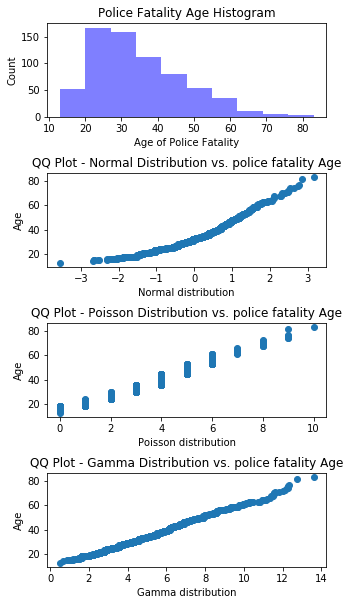

In [5]:
# Making a standard normally distributed variable with 1000 observations,
# a mean of 0, and standard deviation of 1 that we will use as our “comparison.”
norm = np.random.normal(0, 1, 1218)
poisson = np.random.poisson(3, 1218)
gamma = np.random.gamma(5,1, 1218)

# Sorting the values in ascending order.
norm.sort()
poisson.sort()
gamma.sort()


#plots
plt.figure(figsize=(5, 10))
plt.subplots_adjust(hspace=.6)


plt.subplot(4, 1, 1)
plt.hist(x_low_income, color='blue', alpha=.5) 
plt.ylabel('Count')
plt.xlabel('Age of Police Fatality')
plt.title('Police Fatality Age Histogram')


plt.subplot(4, 1, 2)
plt.plot(norm, x_all, "o") 
plt.ylabel('Age')
plt.xlabel('Normal distribution')
plt.title('QQ Plot - Normal Distribution vs. police fatality Age')

plt.subplot(4, 1, 3)
plt.plot(poisson, x_all, "o") 
plt.ylabel('Age')
plt.xlabel('Poisson distribution')
plt.title('QQ Plot - Poisson Distribution vs. police fatality Age')

plt.subplot(4, 1, 4)
plt.plot(gamma, x_all, "o") 
plt.ylabel('Age')
plt.xlabel('Gamma distribution')
plt.title('QQ Plot - Gamma Distribution vs. police fatality Age')



# Question 2:  Does the average age of police fatalities differ between different populations?  Specifically: (1) high income/low income cities, (2) armed/unarmed status of the police fatality, and (3) high population/low population cities?

Next, I've tested whether the average ages differ in high vs. low income cities, and whether or not the armed or unarmed status affects the mean age.  The difference between the average age based on income is not statistically significant, meaning that the average age is not statistically different based on the median income of the city.  

However, there is a statistical difference between unarmed people and armed, where unarmed fatalities are younger on average.  Also, there is a statistical difference between the average age of police fatalities between high and low population cities.

This is supported by t-statistics of 3.45 and 2.58, with pvalues of 0.00077 and .01.  Thus, we reject the null hyptothesis that the means of the two populations are equal.  One way to interpret a t-value is as the number of standard errors worth of space separating the group means. A t-value of 3.45 would indicate that the means are 3.5 standard errors apart.

The p-value associated with a t-test indicates the likelihood of getting a difference this large or larger in the samples if the populations were not different. The smaller the p-value, the more likely the difference we see in the samples meaningfully reflects the populations. The p-value in the test below is really small, so most likely the difference in means is due to a real difference in the population and not due to variability in the samples.

Ttest_indResult(statistic=0.67835465700030084, pvalue=0.49767856144361111)
Ttest_indResult(statistic=3.4508014946481156, pvalue=0.00077169163694452113)
Ttest_indResult(statistic=2.581400095778688, pvalue=0.010128548664743098)


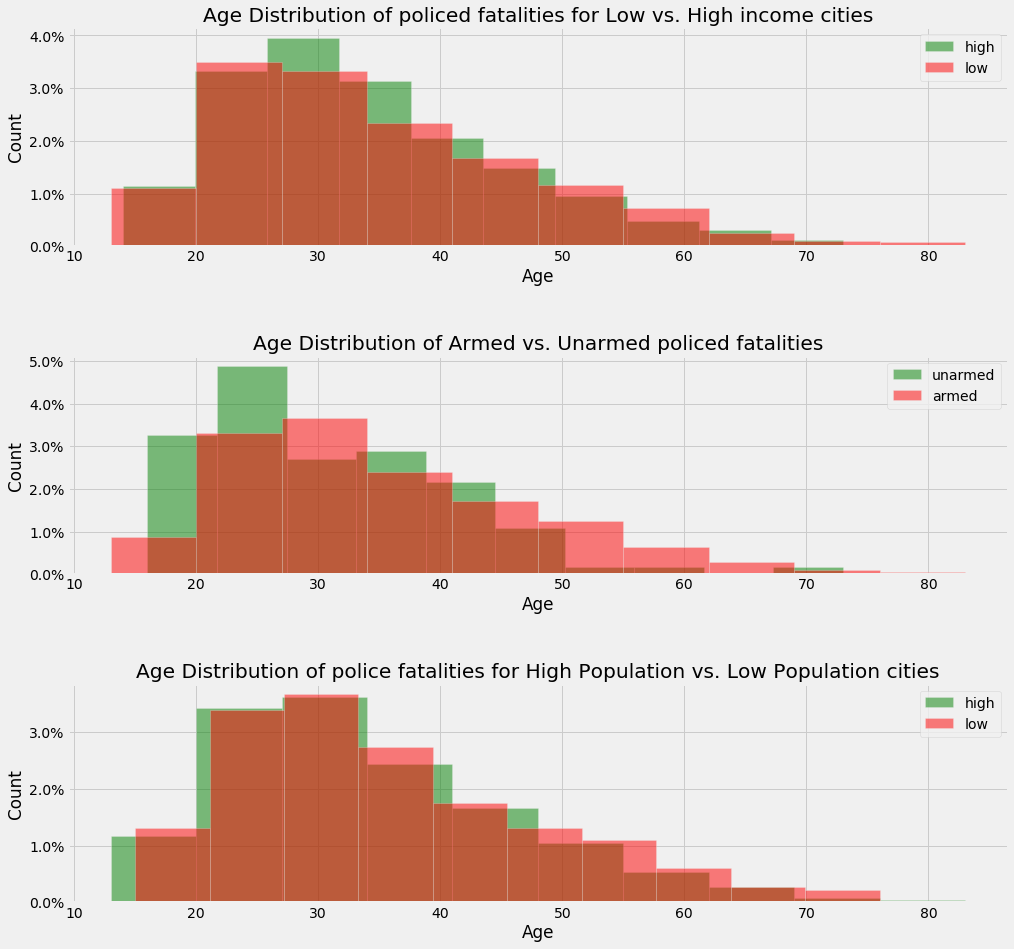

In [90]:
plt.style.use('fivethirtyeight')

#plots
plt.figure(figsize=(15, 15))
plt.subplots_adjust(hspace=.5)

plt.subplot(3, 1, 1)
plt.hist(x_high_income, color='green', alpha=.5, density = 'yes', label='high')
plt.hist(x_low_income, color='red', alpha=.5, density = 'yes', label = 'low') 
plt.ylabel('Count')
plt.xlabel('Age')
plt.title('Age Distribution of policed fatalities for Low vs. High income cities')
plt.legend()
# Set the formatter
formatter = FuncFormatter(to_percent)
plt.gca().yaxis.set_major_formatter(formatter)


plt.subplot(3, 1, 2)
plt.hist(x_unarmed, color='green', alpha=.5, density = 'yes', label = 'unarmed')
plt.hist(x_armed, color='red', alpha=.5, density = 'yes', label = 'armed') 
plt.ylabel('Count')
plt.xlabel('Age')
plt.title('Age Distribution of Armed vs. Unarmed policed fatalities')
plt.legend()
# Set the formatter
formatter = FuncFormatter(to_percent)
plt.gca().yaxis.set_major_formatter(formatter)


plt.subplot(3, 1, 3)
plt.hist(x_high_pop, color='green', alpha=.5, density = 'yes', label = 'high')
plt.hist(x_low_pop, color='red', alpha=.5, density = 'yes', label = 'low') 
plt.ylabel('Count')
plt.xlabel('Age')
plt.title('Age Distribution of police fatalities for High Population vs. Low Population cities')
plt.legend()
# Set the formatter
formatter = FuncFormatter(to_percent)
plt.gca().yaxis.set_major_formatter(formatter)


print(ttest_ind(x_low_income, x_high_income, equal_var=False))
print(ttest_ind(x_armed, x_unarmed, equal_var=False))
print(ttest_ind(x_low_pop, x_high_pop, equal_var=False))

# Question 3:  What is the relationship between income and police fataliites?

First, it's useful look at the the income level and police fatality count per million for cities to understand income levels for cities, as well as expected police fatality counts overall.  It appears that most cities have median incomes between \$40,000 and \$50,000, and annual police fatality counts per million of 3 - 6.

Further, by plotting the annual death count per million against the median income, there appears to be an inverse non linear relationship between fatality count per million people and median income, where higher income cities have lower fatality counts, and the highest fatality counts are happening in lower median income cities.

I then tested whether or not there was a statistical difference in the mean age for police fatalities in cities with high death rate cities vs. low death rate cities.  The t-test indicates that there is a statistical difference between these means, where the average age of a police fatality in a high death rate city is about 35, and is only 32 in a low death rate city.

Ttest_indResult(statistic=-3.0373764349152679, pvalue=0.0024423313085713411)


count    723.000000
mean      35.053942
std       12.323260
min       13.000000
25%       25.000000
50%       32.000000
75%       43.000000
max       83.000000
Name: age, dtype: float64

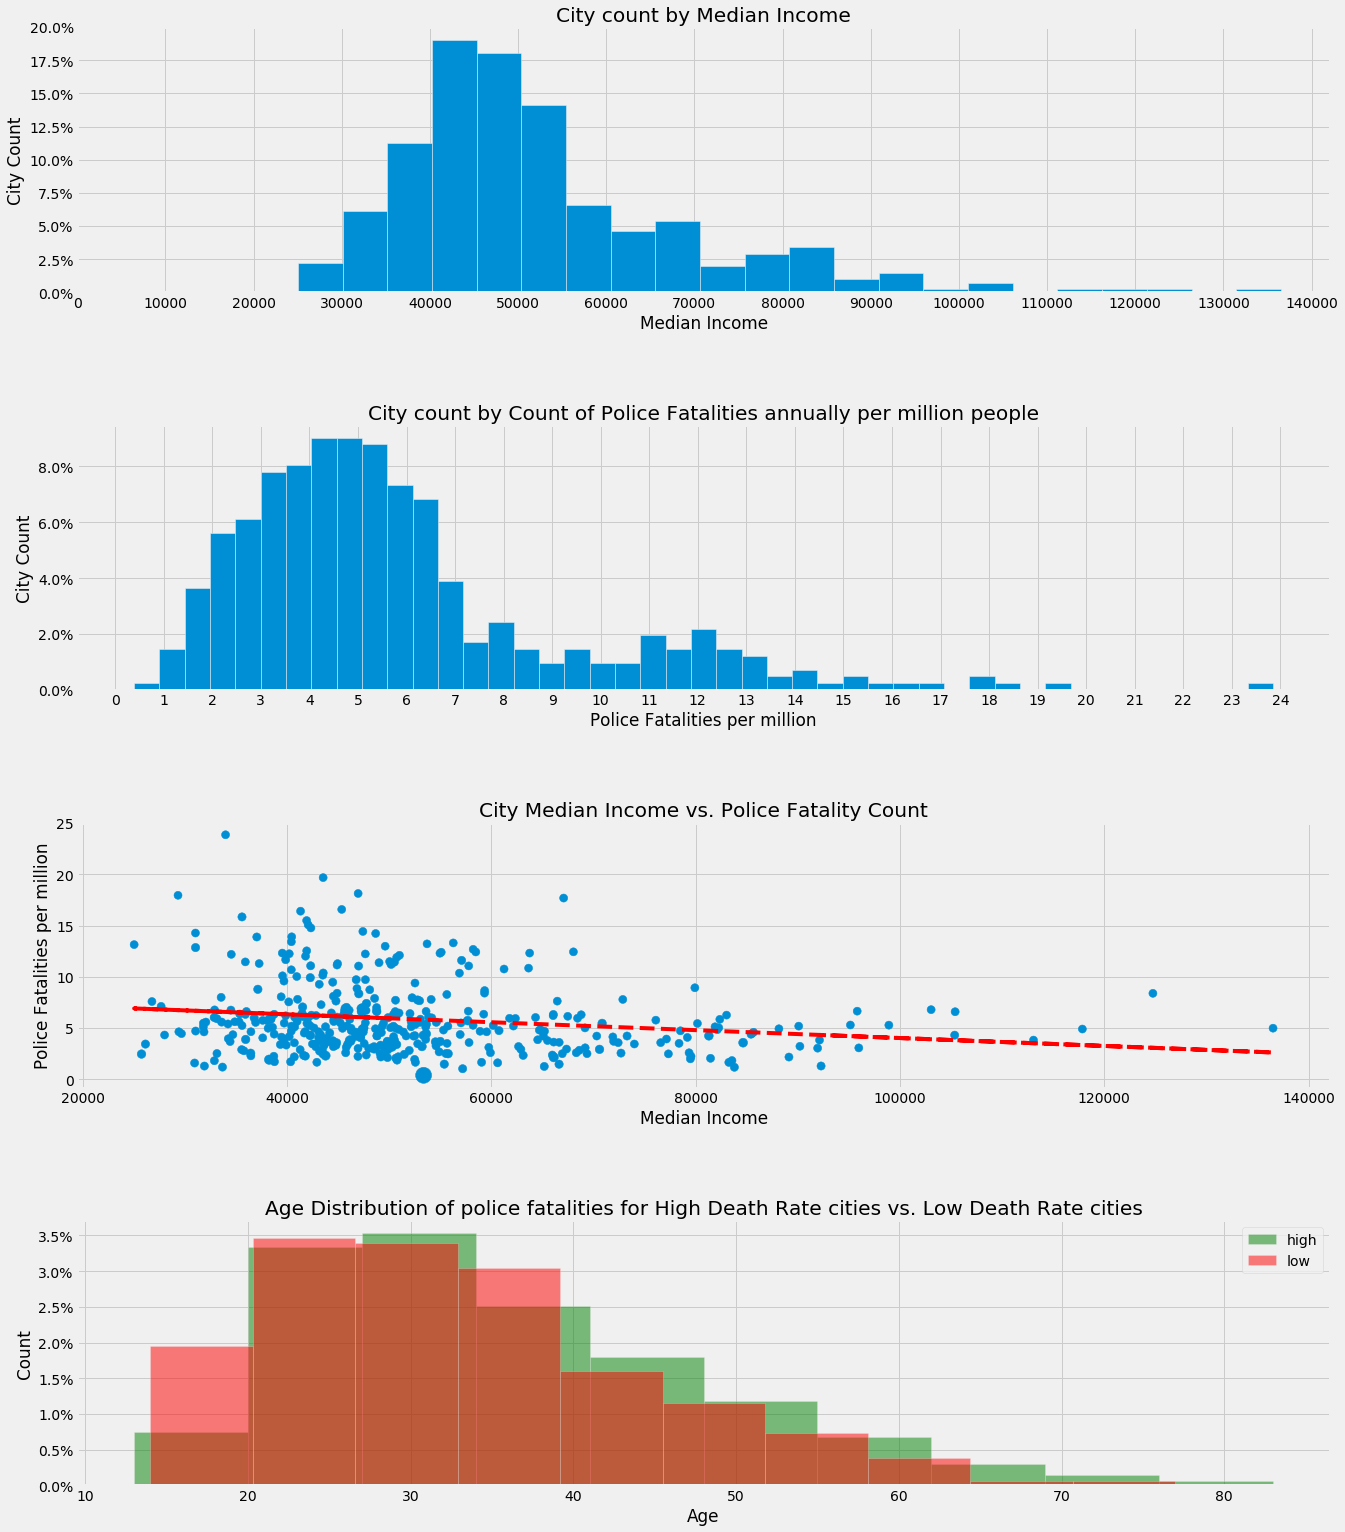

In [95]:
#Plot the data
plt.style.use('fivethirtyeight')
x = df_killings_grouped_city_state_median_population['median_income']
y = df_killings_grouped_city_state_median_population['death_count_per_million_per_year']
z = df_killings_grouped_city_state_median_population['pop']

#weights for histogram
df_killings_grouped_city_state_median_population['weight'] =1
w = df_killings_grouped_city_state_median_population['weight']/len(df_killings_grouped_city_state_median_population)

#size marker for scatter plot
s = lambda z : (((z-z.min())/float(z.max()-z.min())+1)*8)**2


#plots
plt.rcParams["patch.force_edgecolor"] = True
plt.figure(figsize=(20, 25))
plt.subplots_adjust(hspace=.5)


plt.subplot(4, 1, 1)
plt.hist(x,weights=w, bins=22) 
plt.ylabel('City Count')
plt.xlabel('Median Income')
plt.title('City count by Median Income')
plt.xticks([0,10000, 20000, 30000,40000,50000,60000,70000,80000,90000,100000,110000,120000,130000,140000])

# Set the formatter
formatter = FuncFormatter(to_percent)
plt.gca().yaxis.set_major_formatter(formatter)


plt.subplot(4, 1, 2)
plt.hist(y, weights=w, bins=45) 
plt.ylabel('City Count')
plt.xlabel('Police Fatalities per million')
plt.title('City count by Count of Police Fatalities annually per million people')
plt.xticks([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24])
# Set the formatter
formatter = FuncFormatter(to_percent)
plt.gca().yaxis.set_major_formatter(formatter)



plt.subplot(4, 1, 3)
plt.scatter(x, y, s=s(z))
plt.ylabel('Police Fatalities per million')
plt.xlabel('Median Income')
plt.title('City Median Income vs. Police Fatality Count')

z = np.polyfit(x, y, 1)
p = np.poly1d(z)
pylab.plot(x,p(x),"r--")



plt.subplot(4, 1, 4)
plt.hist(x_high_death, color='green', alpha=.5, density = 'yes', label = 'high')
plt.hist(x_low_death, color='red', alpha=.5, density = 'yes', label = 'low') 
plt.ylabel('Count')
plt.xlabel('Age')
plt.title('Age Distribution of police fatalities for High Death Rate cities vs. Low Death Rate cities')
plt.legend()
# Set the formatter
formatter = FuncFormatter(to_percent)
plt.gca().yaxis.set_major_formatter(formatter)

print(ttest_ind(x_low_death, x_high_death, equal_var=False))


x_low_death.describe()
#32.95

x_high_death.describe()
#35.05

## Exploring age distributions in cities with the highest number of police fatalities
Last, I wanted to identify cities with high death rates, and see how the age ranges within these cities differ for at least the top 15 cities.

Los Angeles has seen the most police fatalities over 3 years, with 39 from 2015 - 2017.  Most police fatalities are between the ages of 25-35, but the age distributions differ from city to city.  For example, the age range of police fatalities in Tucson is narrower than Miami.  

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14]),
 <a list of 15 Text xticklabel objects>)

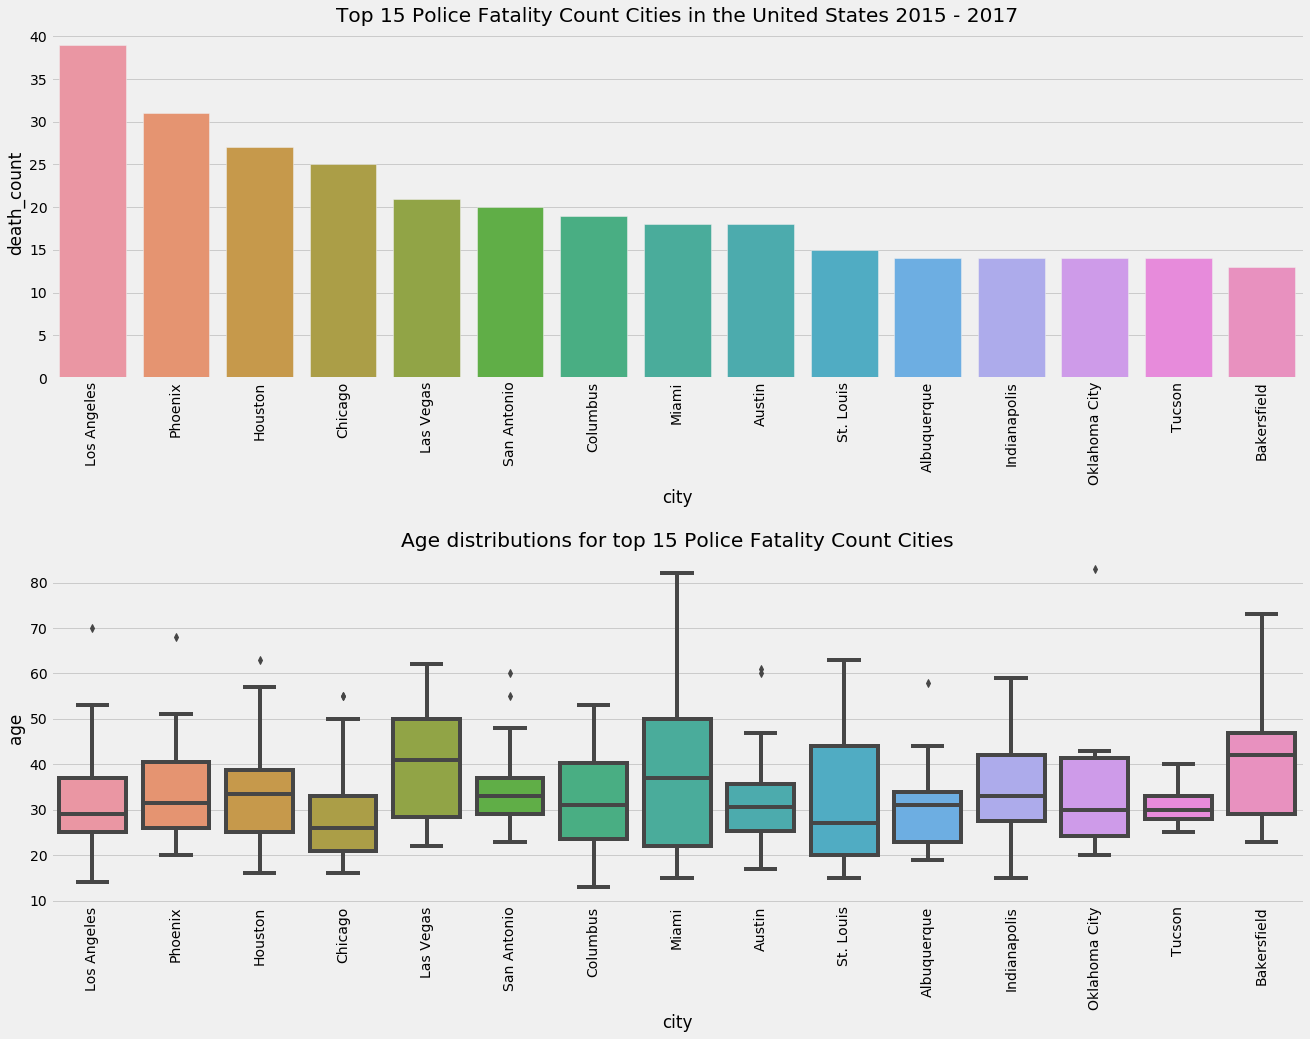

In [96]:
plt.style.use('fivethirtyeight')

#Create dataframe for top 15 cities with most police fatalities
df_top15 = police_killings[['city', 'name']].groupby('city').count().sort_values(['name'], ascending=[False]).head(15)
df_top15.reset_index(level=0, inplace=True)

new_columns = df_top15.columns.values
new_columns[1] = 'death_count'
df_top15.columns = new_columns

#plots
plt.figure(figsize=(20, 15))
plt.subplots_adjust(hspace=.5)

#top 15 counts
plt.subplot(2, 1, 1)
sns.barplot(x="city", y="death_count", data=df_top15)
plt.title('Top 15 Police Fatality Count Cities in the United States 2015 - 2017')
plt.xticks(rotation=90)

#Age ranges for police fatalities
df_top15_with_age_ranges = pd.merge(df_top15, police_killings, on='city', how='left')
plt.subplot(2, 1, 2)
sns.boxplot(x='city', y='age', data=df_top15_with_age_ranges, order=["Los Angeles", "Phoenix", "Houston","Chicago","Las Vegas", "San Antonio", "Columbus", "Miami", "Austin", "St. Louis", "Albuquerque","Indianapolis","Oklahoma City","Tucson","Bakersfield"])
plt.title('Age distributions for top 15 Police Fatality Count Cities')
plt.xticks(rotation=90)

While it's useful to see age ranges for specific cities, the death count itself may be misleading, since it does not account for the city's population.  Therefore, we've analyzed the death count per million people in order to normalize death counts across cities with different populations.  We then divide that by 3 in order to get the annual death count per million by city.  Doing this shows an entirely different set of cities with high police fatality counts, with Hemet CA having almost 25 police fatalities annually per million people.

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14]),
 <a list of 15 Text xticklabel objects>)

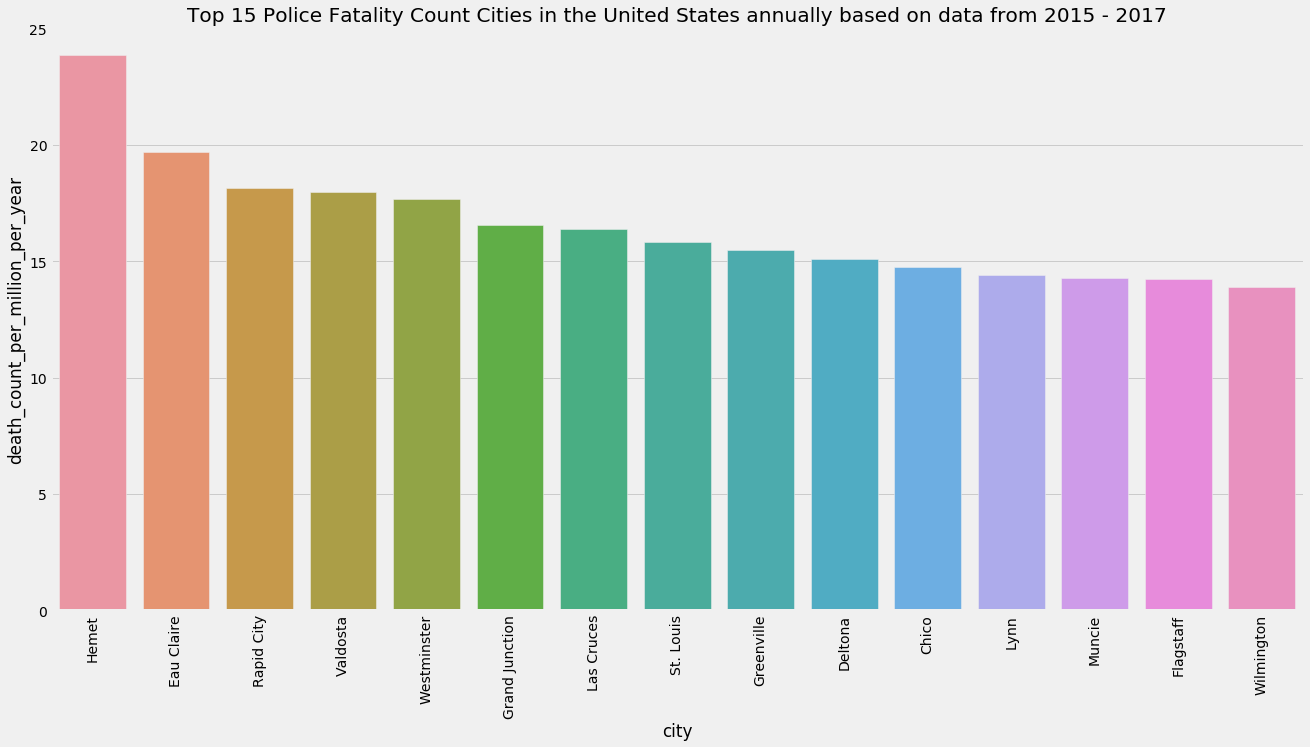

In [97]:
#plots
plt.style.use('fivethirtyeight')
plt.figure(figsize=(20, 10))
plt.subplots_adjust(hspace=.5)

#top 15 counts
plt.subplot(1, 1, 1)
sns.barplot(x="city", y="death_count_per_million_per_year", data=df_top_normalized)
plt.title('Top 15 Police Fatality Count Cities in the United States annually based on data from 2015 - 2017')
plt.xticks(rotation=90)

# Future Research

The above analysis shows that police fatality populations may differ in age based on population size, the armed or unarmed status of the fatality, and the police fatality death rate of the city.  

In the future, I'd like to explore other possible variables affecting the age distribution of police fatalities aside from armed vs. unarmed, income level, population size, and police fatality city death rates such as:

* Mental health status
* Age and other characteristic data for police officer(s) who cause the fatality such to determine if police officers are more or less likely to shoot someone closer in age to them.  For this, I would choose the median age for the police officers who shot and killed an individual, and segment the population into police fatalities by old officer vs. police fatalities young officers.  I'd then conduct a t-test to see if older officers shoot older or younger people on average.
* Number of guns present (illegal and legal) by city to explore the link between police fatalities and gun ownership
* Other crime data to explore the link between police fatality and particular crimes.

Further, I'd like to test whether the age distribution of police fatalities differs from:
* The age distribution in the United States
* The age distribution of fatalities in the United States

A more through understanding of this phenomenon may help identify factors that lead to such differences, and how to mitigate them going forward.